In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import Model, layers
from keras.layers import Conv1D, LSTM, GRU, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Only display tensorflow errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [45]:
df = pd.read_csv('data/comp-merged.csv')
df = df[['value_acc', 'value_met']]
scaler = MinMaxScaler()
df['value_met'] = scaler.fit_transform(df['value_met'].values.reshape(-1, 1))
df['value_acc'] = scaler.transform(df['value_acc'].values.reshape(-1, 1))

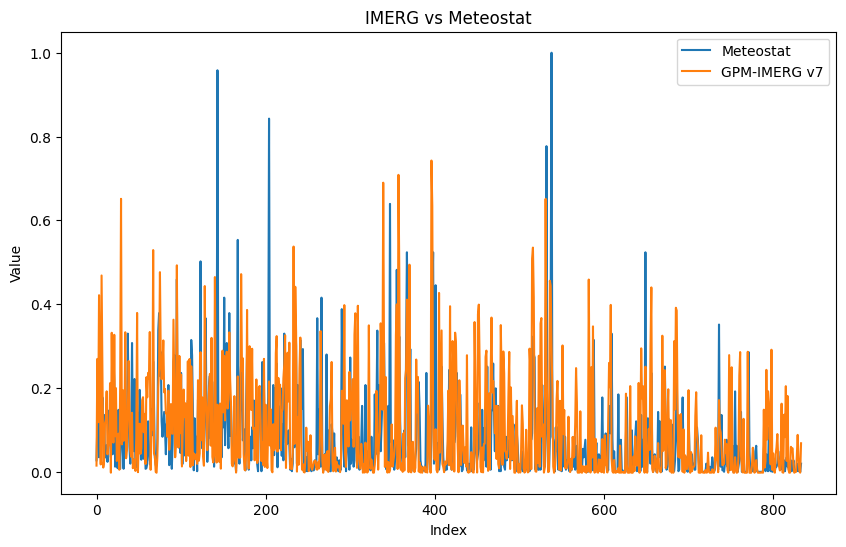

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['value_met'], label='Meteostat')
plt.plot(df['value_acc'], label='GPM-IMERG v7')
plt.title('IMERG vs Meteostat')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [46]:
batch_size = 4
epochs = 1000
window_size = 1

In [47]:
def windowed_dataset(data, window_size, batch_size, shuffle=True):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:, 0], axis=-1), tf.expand_dims(window[:, 1], axis=-1)))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [48]:
def windowed_dataset_single(data, window_size, batch_size):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: tf.expand_dims(window, axis=-1))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [49]:
# Split the dataframe into train and test sets
train, test = train_test_split(df, test_size=0.1, shuffle=False)

train_set = windowed_dataset(train, window_size, batch_size, shuffle=False)
test_set = windowed_dataset(test, window_size, batch_size, shuffle=False)

(4, 1, 1)
(1053,)
(1053,)


/var/folders/xr/qw3ngvrd31dcj2c74gp2t0c00000gn/T/ipykernel_79760/4153096080.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


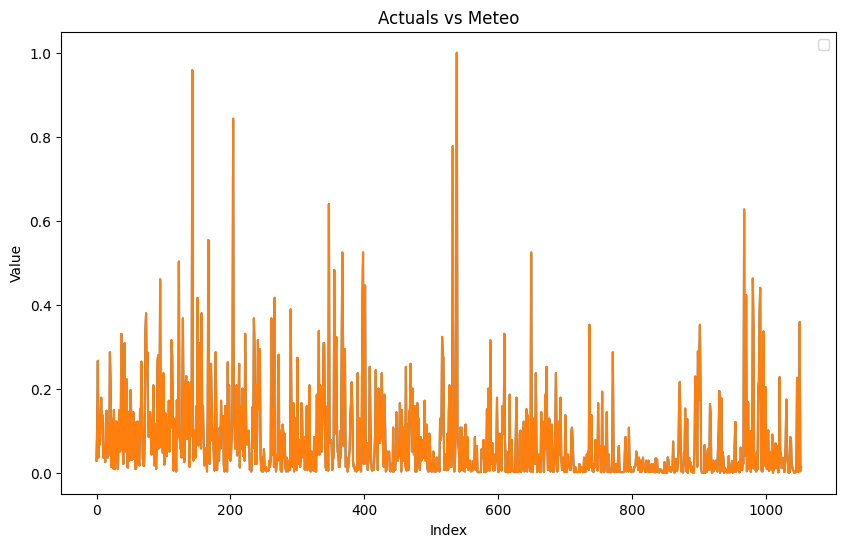

In [50]:
data = windowed_dataset(df, window_size, batch_size, shuffle=False)
actuals = [y for x, y in data]
print(actuals[0].shape)
actuals = np.concatenate(actuals, axis=0).flatten()

print(actuals.shape)
print(df['value_met'].shape)

plt.figure(figsize=(10, 6))
plt.plot(actuals)
plt.plot(df['value_met'])
plt.title('Actuals vs Meteo')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [51]:
class RootMeanSqauredError(keras.metrics.MeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, y_pred, sample_weight)

    def result(self):
        return tf.sqrt(super().result())

In [52]:
def build_model():
    """
    Build a CONV-LSTM model for error correction.
    
    Returns:
    keras.Model: The compiled model
    """
    # Input layer
    inputs = layers.Input(shape=(window_size, 1))
    
    # Convolutional layers
    x = Conv1D(filters=64, kernel_size=2, activation='relu', padding='causal')(inputs)
    # x = MaxPool1D(pool_size=2)(x)
    # x = Conv1D(filters=128, kernel_size=2, activation='relu', padding='causal')(x)
    # x = MaxPool1D(pool_size=2)(x)
    # LSTM layers
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(32, return_sequences=True)(x)
    
    outputs = Conv1D(filters=1, kernel_size=1, activation='linear')(x)
    
    lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=2000,
        decay_rate=0.9
    )

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.AdamW(lr_scheduler), loss='mse', metrics=['mae', RootMeanSqauredError(name='rmse')])
    
    return model

In [53]:
model = build_model()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 1, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 1, 32)          │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 1, 1)           │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,649 (467.38 KB)

 Trainable params: 119,649 (467.38 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history = model.fit(
  train_set,
  epochs=epochs,
  validation_data=test_set,
  verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor='val_rmse', min_delta=1e-6)]
)

Epoch 1/1000
    237/Unknown 5s 14ms/step - loss: 0.0201 - mae: 0.0919 - rmse: 0.1410

/Users/edargham/miniconda3/envs/tf-mac/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0201 - mae: 0.0918 - rmse: 0.1410 - val_loss: 0.0124 - val_mae: 0.0633 - val_rmse: 0.1112
Epoch 2/1000
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0131 - mae: 0.0748 - rmse: 0.1139 - val_loss: 0.0103 - val_mae: 0.0610 - val_rmse: 0.1016
Epoch 3/1000
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0114 - mae: 0.0695 - rmse: 0.1059 - val_loss: 0.0090 - val_mae: 0.0544 - val_rmse: 0.0950
Epoch 4/1000
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0103 - mae: 0.0652 - rmse: 0.1009 - val_loss: 0.0086 - val_mae: 0.0518 - val_rmse: 0.0927
Epoch 5/1000
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0098 - mae: 0.0624 - rmse: 0.0982 - val_loss: 0.0086 - val_mae: 0.0505 - val_rmse: 0.0930
Epoch 6/1000
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0096 - mae: 0.0609 - rmse: 0.0971 - val_loss: 0.0087 - val_mae: 0.0498 - val_rmse: 0.0933
Epoch 7/1000
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0095 - mae: 0.0603

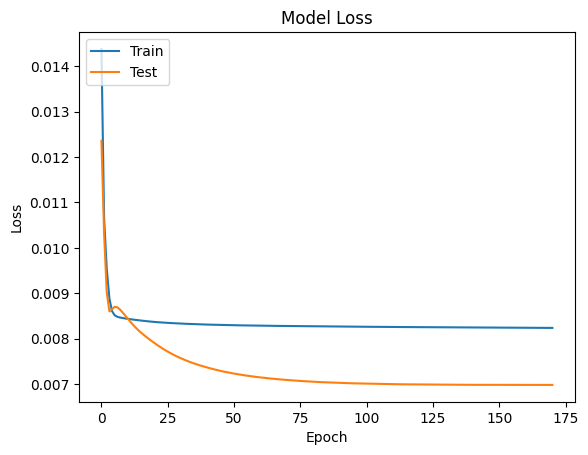

In [56]:
# Plot the loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(106, 1, 1)
(106, 1, 1)


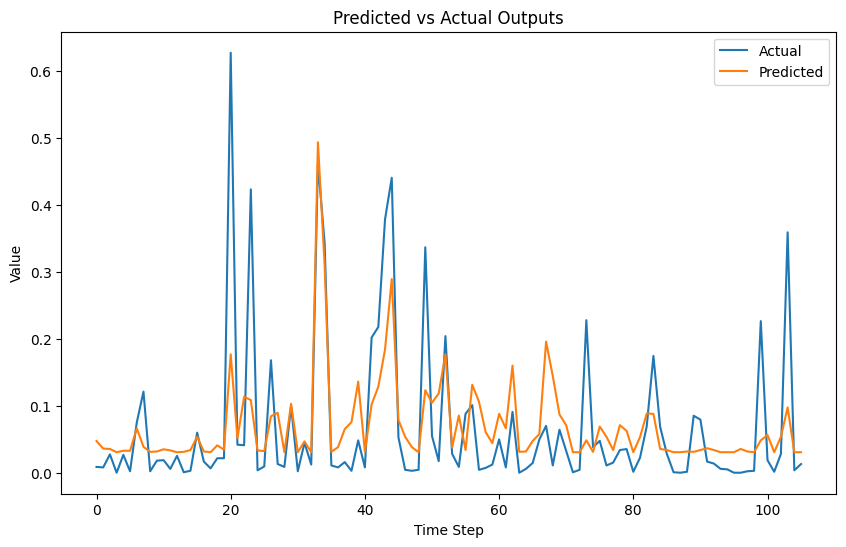

In [57]:
# Make predictions on the test set
predictions = model.predict(test_set)

# Extract the actual values from the test set
actuals = np.concatenate([y for x, y in test_set], axis=0)


print(predictions.shape)
print(actuals.shape)

# Flatten the predictions and actuals
predictions = predictions.flatten()
actuals = actuals.flatten()

# # Inverse transform the predictions and actuals
# predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).flatten()
# actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).flatten()

# Plot the predicted vs actual outputs
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Predicted vs Actual Outputs')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

      1/Unknown 0s 16ms/step

237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


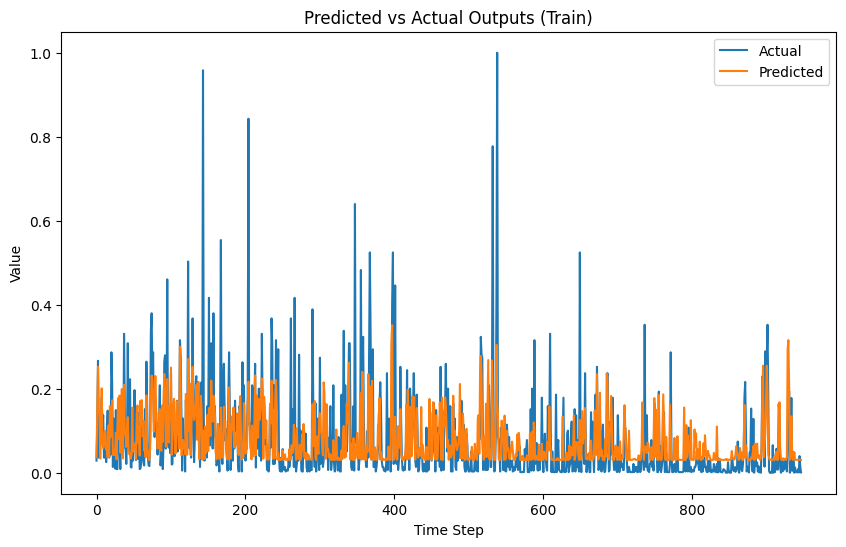

In [58]:
y_pred_train = model.predict(train_set)
y_train = np.concatenate([y for x, y in train_set], axis=0)

y_pred_train = y_pred_train.flatten()
y_train = y_train.flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_pred_train, label='Predicted')
plt.title('Predicted vs Actual Outputs (Train)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [59]:
model.save_weights('corrector-ae.weights.h5')

In [60]:
# Load the 'beirut-daily-precipitation.csv' file
beirut_df = pd.read_csv('data/beirut-daily-precipitation-1hr.csv')

# Create a windowed dataset from df['value'] without shuffling
beirut_values = beirut_df['value'].values
beirut_values = scaler.transform(beirut_values.reshape(-1, 1)).flatten()
beirut_dataset = windowed_dataset_single(beirut_values, window_size, batch_size)

# Pass the windowed dataset to the model for inference
predictions = model.predict(beirut_dataset)

# Unwrap the windows
corrected_values = predictions.flatten()

# Inverse transform the corrected values
corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 1)).flatten()

# corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 2)).flatten()
print(len(corrected_values))
print(len(beirut_df))

# Save the outputs to 'beirut-daily-corrected.csv'
beirut_df = beirut_df[:len(corrected_values)]
beirut_df['value'] = corrected_values
beirut_df.to_csv('data/beirut-daily-corrected.csv', index=False)

2192/2192 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


/Users/edargham/miniconda3/envs/tf-mac/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8766
8766
